In [2]:
import netCDF4 as nc
from pprint import pprint
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from bs4 import BeautifulSoup
from dateutil.relativedelta import relativedelta

## Explore netCDF HEMCO geographical emissions data

For some cool plotting we could try using NASA's Panoply. Other PLs might support better netCDF data interfaces, like R, MATLAB, etc.

In [13]:
ds = nc.Dataset('./data/2018/OC-em-anthro_CMIP_CEDS_2018.nc', format="NETCDF4")
pprint(ds.dimensions)

{'lat': <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 360,
 'lon': <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 720,
 'time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 12}


In [14]:
metadata = ds.__dict__
print(metadata['title'])
# print(metadata['VOC_name'])
print(metadata['frequency'])
# print(metadata['molecular_weight'], metadata['molecular_weight_unit'])
print(metadata['nominal_resolution'])
print(metadata['realm'])
# metadata

Annual Anthropogenic Emissions of OC prepared for input4MIPs
mon
50 km
atmos


In [15]:
ds.__dict__

{'CDI': 'Climate Data Interface version 1.9.4 (http://mpimet.mpg.de/cdi)',
 'history': 'Thu Jun 24 17:26:19 2021: cdo selyear,2018 ./2000-2019/OC-em-anthro_CMIP_CEDS_200001-201912.nc OC-em-anthro_CMIP_CEDS_2018.nc\nWed Jun 23 18:23:53 2021: ncks -x -v lon_bnds,time_bnds,lat_bnds tmp.nc tmp2.nc\nWed Jun 23 18:23:52 2021: ncatted -a bounds,,d,, ./v2021-06/OC-em-anthro_CMIP_CEDS_200001-201912.nc tmp.nc\nWed Jun 23 18:23:26 2021: cdo setreftime,1950-01-01,0 fixtime.nc tmp.nc\nWed Jun 23 18:23:19 2021: cdo setcalendar,standard fixtime.nc tmp.nc\nWed Jun 23 18:22:35 2021: cdo -s merge new.nc tmp.nc tmp2.nc\nWed Jun 23 18:21:51 2021: cdo -s merge new.nc tmp.nc tmp2.nc\nWed Jun 23 18:21:17 2021: cdo -s merge new.nc tmp.nc tmp2.nc\nWed Jun 23 18:20:52 2021: cdo -s merge new.nc tmp.nc tmp2.nc\nWed Jun 23 18:20:16 2021: cdo -s merge new.nc tmp.nc tmp2.nc\nWed Jun 23 18:19:53 2021: cdo -s merge new.nc tmp.nc tmp2.nc\nWed Jun 23 18:19:37 2021: cdo -s merge new.nc tmp.nc tmp2.nc\nWed Jun 23 18:19:07

In [1]:
for var in ds.variables:
    print(f"{var}: {ds.variables[var].long_name}")

NameError: name 'ds' is not defined

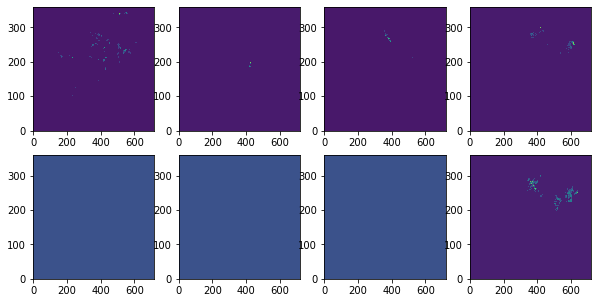

In [145]:
f, axs = plt.subplots(2,4, figsize = (10,5))
axs[0, 0].contourf(ds.variables['N2O_agr'][:][0])
axs[0, 1].contourf(ds.variables['N2O_ene'][:][0])
axs[0, 2].contourf(ds.variables['N2O_ind'][:][0])
axs[0, 3].contourf(ds.variables['N2O_rco'][:][0])
axs[1, 0].contourf(ds.variables['N2O_shp'][:][0])
axs[1, 1].contourf(ds.variables['N2O_slv'][:][0])
axs[1, 2].contourf(ds.variables['N2O_tra'][:][0])
axs[1, 3].contourf(ds.variables['N2O_wst'][:][0])

plt.show()

## Getting CEDS data for Los Angeles North Main Street

In [56]:
# 12 months of data, one data point for each month/lat/lon?
print(ds.variables['lon'][:].shape)
print(ds.variables['lat'][:].shape)
print(ds.variables['time'][:].shape)
print(ds.variables['N2O_tra'][:].shape)

print(ds.variables['N2O_tra'][:][0][0][0])
print(ds.variables['lat'][:][0])
print(ds.variables['lon'][:][0])
print(ds.variables['time'][:][0])

(720,)
(360,)
(12,)
(12, 360, 720)
0.0
-89.75
-179.75
-71587.0


### Get just data for N2O in df

In [100]:
def get_compound_df(path, site_lat, site_lon):
    ds = nc.Dataset(path, format="NETCDF4")
    lat_idx = np.where(ds.variables['lat'][:] == site_lat)
    lon_idx = np.where(ds.variables['lon'][:] == site_lon)
    
    data = []
    for var in ds.variables:
        if var not in ['time', 'lat', 'lon']:
            data.append(ds.variables[var][:][:, lat_idx, lon_idx].flatten())
    
    data = np.asarray(data).T
    df = pd.DataFrame(data, columns = [x for x in ds.variables if x not in ['time', 'lat', 'lon']])
    df.index = ds.variables['time'][:]
    return df

# Get all data

In [51]:
# Get all URLS
url = 'http://ftp.as.harvard.edu/gcgrid/data/ExtData/HEMCO/CEDS/v2021-06/2018/'
r = requests.get(url)
soup = BeautifulSoup(r.text, "html.parser")
links = []
for link in soup.findAll('a'):
    links.append(link.get('href'))
nc_links = links[5:]

In [55]:
for endpoint in nc_links:
    r = requests.get(url + endpoint)
    open('./data/2018/' + endpoint, 'wb').write(r.content)

## Merge and resample as daily data

In [103]:
# NOTE: The HEMCO CEDS netcdf files use bounding box every 50 km, so we want the closest box (34.25, -118.25) to LA
la_lat = 34.25
la_lon = -118.25

def make_ceds_df(lat, lon, nc_links):
    dfs = []
    for endpoint in nc_links:
        df = get_compound_df('./data/2018/' + endpoint, lat, lon)
        dfs.append(df)

    full_df = dfs[0].join(dfs[1:], how='outer')

    # NOTE: Not sure how to convert to timestamp so I will just convert to the first of the month for the given year
    start = datetime.datetime(2018, 1, 1, 0, 0)
    dates = [start + relativedelta(months=i) for i in range(0, 12)]
    full_df.index = dates 
    full_df.loc[datetime.datetime(2018, 12, 31, 23, 0)] = full_df.loc[datetime.datetime(2018, 12, 1)] # Repeat last row
    full_df = full_df.asfreq(freq='1h', method='ffill')

    return full_df

df = make_ceds_df(la_lat, la_lon, nc_links)
df

,ALD2_agr,ALD2_ene,ALD2_ind,ALD2_rco,ALD2_shp,ALD2_slv,ALD2_tra,ALD2_wst,ALK4_butanes_agr,ALK4_butanes_ene,...,TOLU_tra,TOLU_wst,XYLE_agr,XYLE_ene,XYLE_ind,XYLE_rco,XYLE_shp,XYLE_slv,XYLE_tra,XYLE_wst
2018-01-01 00:00:00,0.0,1.268880e-15,3.655395e-14,4.180411e-13,0.0,0.0,1.599644e-13,1.295176e-13,0.0,1.349363e-12,...,1.650062e-12,3.429407e-13,0.0,2.333671e-13,1.001630e-11,1.231820e-13,1.085941e-14,4.498998e-11,1.357164e-12,2.165785e-13
2018-01-01 01:00:00,0.0,1.268880e-15,3.655395e-14,4.180411e-13,0.0,0.0,1.599644e-13,1.295176e-13,0.0,1.349363e-12,...,1.650062e-12,3.429407e-13,0.0,2.333671e-13,1.001630e-11,1.231820e-13,1.085941e-14,4.498998e-11,1.357164e-12,2.165785e-13
2018-01-01 02:00:00,0.0,1.268880e-15,3.655395e-14,4.180411e-13,0.0,0.0,1.599644e-13,1.295176e-13,0.0,1.349363e-12,...,1.650062e-12,3.429407e-13,0.0,2.333671e-13,1.001630e-11,1.231820e-13,1.085941e-14,4.498998e-11,1.357164e-12,2.165785e-13
2018-01-01 03:00:00,0.0,1.268880e-15,3.655395e-14,4.180411e-13,0.0,0.0,1.599644e-13,1.295176e-13,0.0,1.349363e-12,...,1.650062e-12,3.429407e-13,0.0,2.333671e-13,1.001630e-11,1.231820e-13,1.085941e-14,4.498998e-11,1.357164e-12,2.165785e-13
2018-01-01 04:00:00,0.0,1.268880e-15,3.655395e-14,4.180411e-13,0.0,0.0,1.599644e-13,1.295176e-13,0.0,1.349363e-12,...,1.650062e-12,3.429407e-13,0.0,2.333671e-13,1.001630e-11,1.231820e-13,1.085941e-14,4.498998e-11,1.357164e-12,2.165785e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30 20:00:00,0.0,1.270339e-15,3.655395e-14,4.400093e-13,0.0,0.0,1.599644e-13,1.295176e-13,0.0,1.350914e-12,...,1.650062e-12,3.429407e-13,0.0,2.336354e-13,1.001630e-11,1.296552e-13,1.147636e-14,4.498998e-11,1.357164e-12,2.165785e-13
2018-12-30 21:00:00,0.0,1.270339e-15,3.655395e-14,4.400093e-13,0.0,0.0,1.599644e-13,1.295176e-13,0.0,1.350914e-12,...,1.650062e-12,3.429407e-13,0.0,2.336354e-13,1.001630e-11,1.296552e-13,1.147636e-14,4.498998e-11,1.357164e-12,2.165785e-13
2018-12-30 22:00:00,0.0,1.270339e-15,3.655395e-14,4.400093e-13,0.0,0.0,1.599644e-13,1.295176e-13,0.0,1.350914e-12,...,1.650062e-12,3.429407e-13,0.0,2.336354e-13,1.001630e-11,1.296552e-13,1.147636e-14,4.498998e-11,1.357164e-12,2.165785e-13
2018-12-30 23:00:00,0.0,1.270339e-15,3.655395e-14,4.400093e-13,0.0,0.0,1.599644e-13,1.295176e-13,0.0,1.350914e-12,...,1.650062e-12,3.429407e-13,0.0,2.336354e-13,1.001630e-11,1.296552e-13,1.147636e-14,4.498998e-11,1.357164e-12,2.165785e-13


### Takeaways
Datasets are separated by different chemical compounds. The .nc files contain metadata, dimensions, and variables. The dimensions denote how the variables are separated indexed in the dataset (I think?). In these datasets we have 3 dimensions, time, latitude, and longitude. The latitude and longitude granularity is usually 50 kms. This is why each of the timeseries data for the actual compound vars are 3-dimensional. They have data at a particular longitude, for a particular latitude, at a particular time. We can plot using some of the 3D plotting tools on matplotlib or on Panoply. Furthermore, variables are split up by the type of emission, for example solvent or agriculture.